<a href="https://colab.research.google.com/github/Rohan-1103/Data-Science/blob/main/NLP/newsdataset_clustering_using_k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps for performing the cluster analysis:
1. Loading or preparing the dataset
2. Preprocessing of the dataset
3. Vectorizing the text using TfidfVectozer
4. Cluster the documents
5. Plot the clusters using matplotlib

First we need to import the necessary libraries:

In [1]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import pandas as pd
import numpy as np

## 1. Loading Dataset

In [2]:
dataset = fetch_20newsgroups(subset='all', shuffle=False, remove=('headers', 'footers', 'quotes'))
print(type(dataset))

<class 'sklearn.utils._bunch.Bunch'>


In [3]:
# dataset.data[:5]

In [4]:
print('First 5 documents from the dataset:')
for i, doc in enumerate(dataset.data[:5]):
    print(f'-- Document {i+1} --\n{doc}\n')

First 5 documents from the dataset:
-- Document 1 --

morgan and guzman will have era's 1 run higher than last year, and
 the cubs will be idiots and not pitch harkey as much as hibbard.
 castillo won't be good (i think he's a stud pitcher)

-- Document 2 --
Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wouldn't c

In [5]:
print('Value counts for categories:')
category_names = [dataset.target_names[i] for i in dataset.target]
category_counts = pd.Series(category_names).value_counts()
print(category_counts)

Value counts for categories:
rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          994
sci.crypt                   991
sci.med                     990
rec.autos                   990
comp.windows.x              988
sci.space                   987
comp.os.ms-windows.misc     985
sci.electronics             984
comp.sys.ibm.pc.hardware    982
misc.forsale                975
comp.graphics               973
comp.sys.mac.hardware       963
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64


## 2. Preprocessing Dataset

In [6]:
# Selected 3 categories from the 20 newsgroups dataset
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


In [7]:
subdataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

In [8]:
labels = subdataset.target
print(labels.shape)
true_k = len(np.unique(labels)) ## This should be 3 in this example
print(true_k)

(2588,)
3


### Perform Lemmatization

Lemmatization in linguistics is the process of grouping together the inflected forms of a word so they can be analysed as a single item, identified by the word's lemma, or dictionary form.
Steps:
* initialize the Lemmatizer
* iterate through the dataset and then:
  * tokenize each entry - splits the text in the data[i] row into a list of individual words (tokens)
  * Lemmatize each word
  * update the dataframe

-----------------------------------------------------------------------------------------------------
Example:

*initial data*

0  The cats are running faster than dogs.

1  Better technologies make work easier.

*output*

0  The cat are run faster than dog .

1  Better technology make work easier .


In [9]:
import nltk
nltk.download(['punkt_tab', 'wordnet'])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [10]:
lemmatizer = WordNetLemmatizer()
for i in range(len(dataset.data)):
    word_list = word_tokenize(dataset.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    dataset.data[i] = lemmatized_doc

In [11]:
print(dataset.data[1])

 Well , I just got my Centris 610 yesterday . It took just over two week from placing the order . The dealer ( Rutgers computer store ) appologized because Apple made a substitution on my order . I ordered the one without ethernet , but they substituted one _with_ ethernet . He wanted to know if that would be `` alright with me '' ! ! ! They must be backlogged on Centri w/out ethernet so they 're just shipping them with ! Anyway , I 'm very happy with the 610 with a few exception . Being nosy , I decided to open it up _before_ powering it on for the first time . The SCSI cable to the hard drive wa only partially connected ( must have come loose in shipping ) . No big deal , but I would have been pissed if I tried to boot it and it would n't come up ! The hard drive also ha an annoying high pitched whine . I 've heard apple will exchange it if you complain , so I might try to get it swapped . I am also dissappionted by the lack of soft power-on/off . This wa n't mentioned in any of the 

In the text clustering problem, the **TfidfVectorizer** plays a crucial role in converting the text  into numerical representations that can be processed by machine learning algorithms. Here’s how it works:
* Machine learning models work with numerical data. The TfidfVectorizer transforms text documents into numerical vectors, where each document is represented as a vector in a high-dimensional space.
* **TF-IDF** is a statistical measure used to evaluate the importance of a word in a document relative to a collection of documents (the corpus).
* * **TF (Term Frequency)**: Measures how often a word occurs in a document.
* * **IDF (Inverse Document Frequency)**: Reduces the weight of commonly occurring words (like "the," "and," etc.) across all documents and increases the weight of rare words that are more unique to specific documents.
* The **stop_words='english'** parameter removes common English stop words (e.g., "is," "and," "the") that usually do not carry significant meaning for clustering. This reduces noise and improves clustering performance.
* After the **TF-IDF transformation**, each document is represented as a **sparse vector**, where most values are zero (indicating words not present in the document). These vectors capture the essence of the documents based on their textual content.
* The generated vectors are used to compute similarities (e.g., cosine similarity) between documents. Documents with similar vectors are considered similar in content, aiding the clustering process.

We next convert our corpus into tf-idf vectors. We remove common stop words, terms with very low document frequency (many of them are numbers or misspells), accents - specifically terms that are not present in at least 2 documents (set by min_df = 2)

In [12]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(dataset.data)

In [13]:
print(X.shape)

(18846, 49386)


### Clustering using standard k-means

We first cluster documents using the standard k-means algorithm without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We may try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases and stop when it starts decreasing.

In this specific case, we set $k = 3$ of course

In [14]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

done in 1.059s


### Identify the 10 most relevant terms in each cluster

* *km.cluster_centers_* ->  contains the coordinates of the cluster centroids in the feature space - for text data these are the term frequencies.
We will sort it in descending order
* we get the feature names (terms) from the vectorizer used to preprocess the text
* loop over all the cluser, retrieve and print the first 10 indices from the sorted list of term indices

In [15]:
# vectorizer.get_feature_names

In [16]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: file drive card thanks windows window program problem know use
Cluster 1: ha just like know wa game good think car doe
Cluster 2: wa people god did think just say ha know right


### Visualization using WordCloud

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

We define a method to calculate the frecquency of terms for a cluster
In k-means clustering, cluster_centers_ contains the coordinates of the centroids for each cluster. For text data, these represent term frequencies. Then we will retrieve a list of terms associated with the cluster, which are sorted by their frecquencies.
Then we will create a dictionary where the keys will be the indices and the values the respectives frequencies, which we will return.


In [18]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

In [19]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

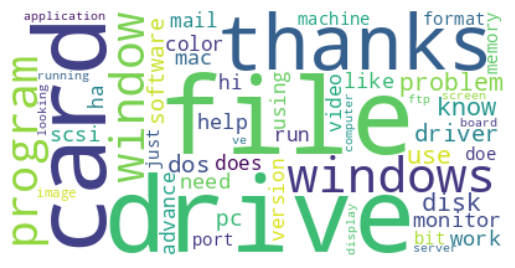

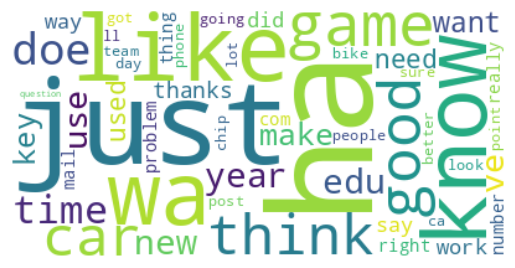

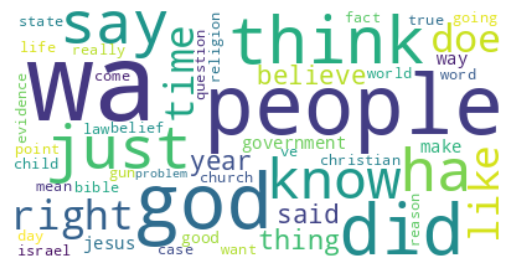

In [20]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()